# Chicken Weights by Feed Type

## Dataset

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

*Source: Anonymous (1948) Biometrika, 35, 214.*

## Questions to Answer

We want to know: 1) is there a significant difference in weights amongst the various feed types; and, 2) if so, what is the probability that a specific feed type will outperform other feed types.

## Summary

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

We model the problem using the hierarchical model:

$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu, \tau) $$


The hierarchical model assumes that each group mean $\theta_j$ comes from a separate distribution, but share a common variance $\sigma^2$. It also assumes that $\theta_j$ shares a prior distribution.

There is a statisticaly significant difference in weights amongst the various feed types, particularly when comparing casein or sunflower to the other four.

Probability that sunflower > casein: 0.5257
Probability that sunflower > horsebean: 0.9722
Probability that sunflower > linseed: 0.8944
Probability that sunflower > meatmeal: 0.7158
Probability that sunflower > soybean: 0.8265

While sunflower feed outperforms the other four types with probability of 71% probability or more, it's unclear that it will outperform casein. Posterior predictive samples estimate that sunflower feed will only outperform casein 52% of the time.  Given the choice between sunflower or casein feeds, it's better to choose the least expensive.

## Required Packages

In [3]:
library(tidyverse)
library(rjags)
library(glue)

source("funcs.R")

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



## Data

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

In [4]:
data = datasets::chickwts %>%
  mutate(
    feed_name = feed,
    feed = as.numeric(feed)
    )

In [5]:
str(data)

'data.frame':	71 obs. of  3 variables:
 $ weight   : num  179 160 136 227 217 168 108 124 143 140 ...
 $ feed     : num  2 2 2 2 2 2 2 2 2 2 ...
 $ feed_name: Factor w/ 6 levels "casein","horsebean",..: 2 2 2 2 2 2 2 2 2 2 ...


In [6]:
head(data)

,weight,feed,feed_name
,<dbl>,<dbl>,<fct>
1,179,2,horsebean
2,160,2,horsebean
3,136,2,horsebean
4,227,2,horsebean
5,217,2,horsebean
6,168,2,horsebean


In [7]:
table(data$feed_name)


   casein horsebean   linseed  meatmeal   soybean sunflower 
       12        10        12        11        14        12 

### Distribution of Weights by Feed Type

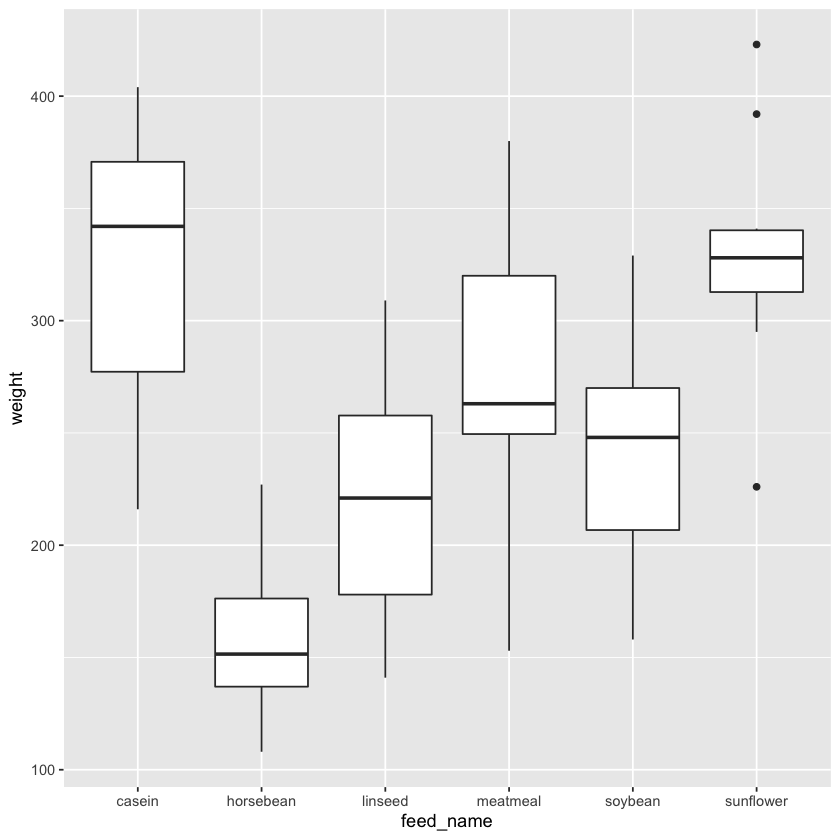

In [8]:
ggplot(data, aes(x=feed_name, y=weight, group=feed_name)) +
  geom_boxplot()

In [9]:
data %>%
    filter(feed_name=="sunflower")

weight,feed,feed_name
<dbl>,<dbl>,<fct>
423,6,sunflower
340,6,sunflower
392,6,sunflower
339,6,sunflower
341,6,sunflower
226,6,sunflower
320,6,sunflower
295,6,sunflower
334,6,sunflower


## Models

### Base Linear Model

We'll user a linear model as a base, and fit without an intercept for easy interpretation and comparison with other methods. Our results mirror the boxplots-- casein and sunflower feeds appear associated with higher weights, but there doesn't seem to be a clear winner amongst the top two. The residuals don't show a clear pattern.

Before analysis, we'll shuffle the dataset so that the observations are not grouped by factor order. 

In [10]:
set.seed(43)
idx = sample(c(1:nrow(data)), nrow(data))
data = data[idx,]

In [11]:
mod.base = lm(weight ~ feed_name + 0, data=data)
summary(mod.base)


Call:
lm(formula = weight ~ feed_name + 0, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-123.909  -34.413    1.571   38.170  103.091 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
feed_namecasein      323.58      15.83  20.436  < 2e-16 ***
feed_namehorsebean   160.20      17.35   9.236 1.91e-13 ***
feed_namelinseed     218.75      15.83  13.815  < 2e-16 ***
feed_namemeatmeal    276.91      16.54  16.744  < 2e-16 ***
feed_namesoybean     246.43      14.66  16.810  < 2e-16 ***
feed_namesunflower   328.92      15.83  20.773  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.85 on 65 degrees of freedom
Multiple R-squared:  0.9629,	Adjusted R-squared:  0.9595 
F-statistic: 281.4 on 6 and 65 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



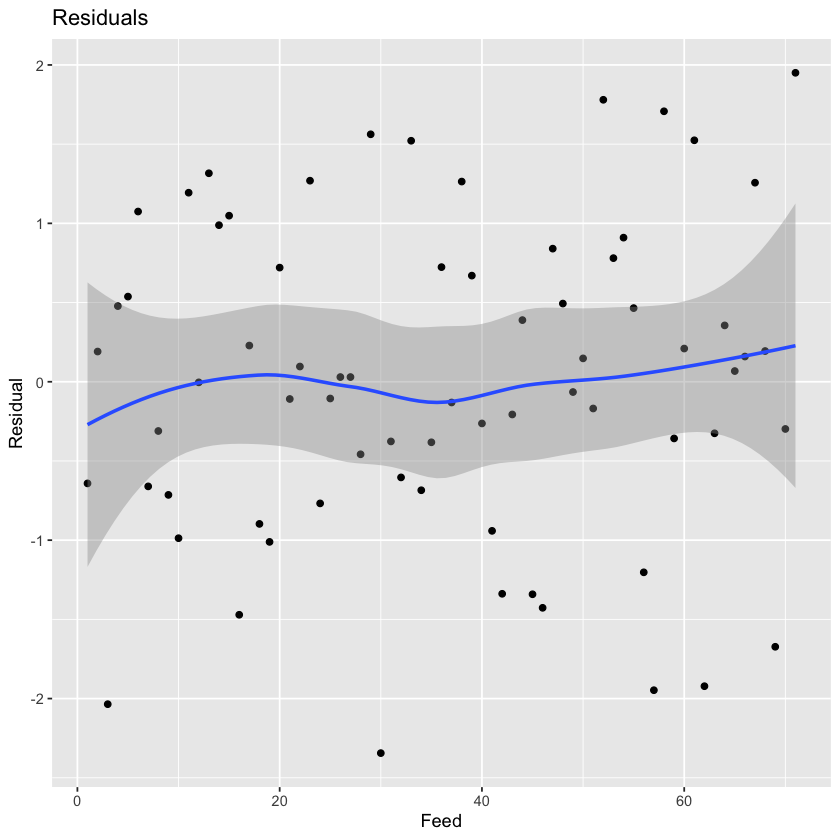

In [12]:
res = data$weight - mod.base$fitted.values
gg_resid(res, normalize=TRUE)

### Pooled Model

The pooled model assumes that each observation $i$ from group $j$ comes from the same distribution:

$$ Weight_{ij} \sim Normal(\mu, \sigma) $$

This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.

Penalized deviance: 823.2 

Convergence looks fine, but the residuals show some trend. When plotted by feed name, it's evident that the pooled model is inappropriate.

In [13]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(mu, prec)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec ~ dexp(1)
  sigma = sqrt(1/prec)
} "

set.seed(43)
data_jags = as.list(data)
params = c("mu", "sigma")

mod.pooled = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed" in data”
Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 2
   Total graph size: 79

Initializing model



#### Results

In [14]:
summary(mod.pooled$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean    SD Naive SE Time-series SE
mu    261.2 9.297  0.07591        0.07493
sigma  77.7 6.512  0.05317        0.05381

2. Quantiles for each variable:

        2.5%    25%    50%   75%  97.5%
mu    242.83 255.04 261.24 267.3 279.53
sigma  66.19  73.15  77.31  81.9  91.27


In [15]:
round(mod.pooled$coefs, 4)

mu    sigma 
261.1777  77.6987

In [16]:
(dic.pooled = dic.samples(mod.pooled$obj, n.iter=1e3))

Mean deviance:  821.3 
penalty 2.042 
Penalized deviance: 823.3 

#### Convergence

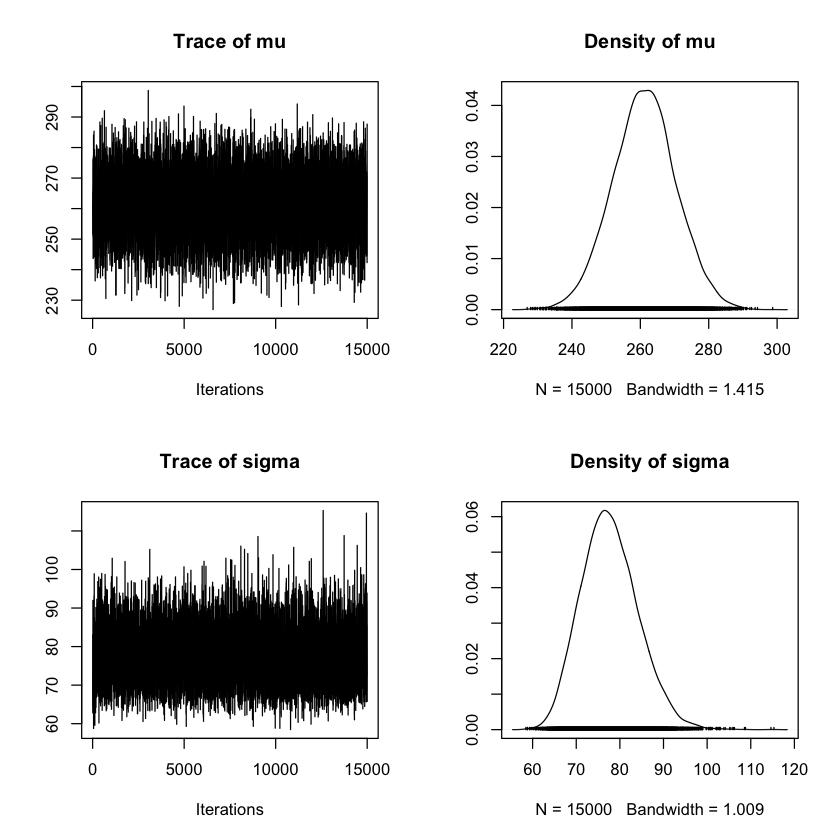

In [17]:
plot(mod.pooled$csim)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



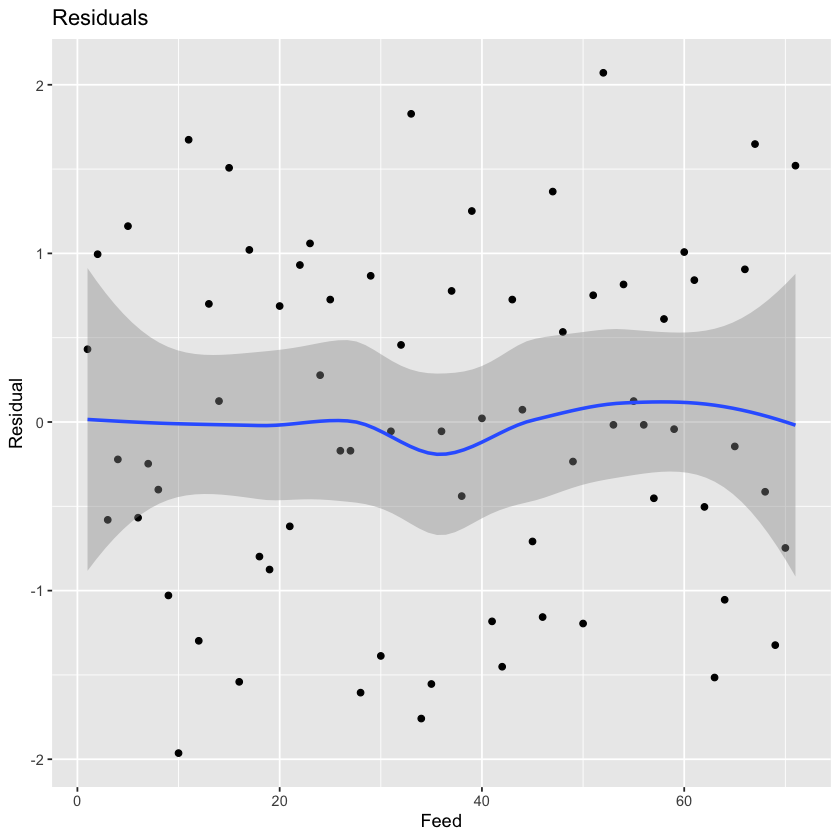

In [18]:
res = data$weight - mod.pooled$coefs[1]
gg_resid(res, normalize=TRUE)

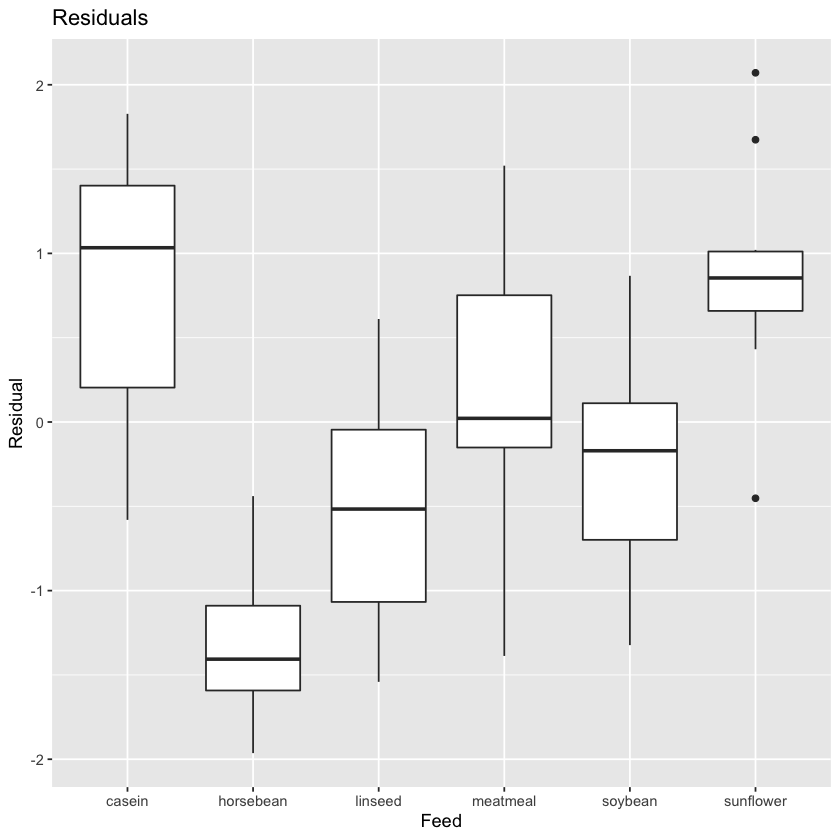

In [19]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Hierarchical Model

### Homogenous Variance

The hierarchical model assumes that each group mean $\theta_j$ comes from a separate distribution, but share a common variance $\sigma^2$. It also assumes that $\theta_j$ shares a prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu, \tau) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates an overall mean $\mu$ of approximately 258.8871 and standard deviation $\sigma$ of approximately 54.8379. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[317.4984, 170.3849, 222.3934, 275.2269, 247.3577, 322.5068\].

Penalized deviance: 778.5 

Convergence looks fine, and the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [20]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  prec.sigma ~ dexp(1)
  tau = sqrt(1/prec.tau)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 9
   Total graph size: 159

Initializing model



#### Results

In [21]:
summary(mod.hier$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
mu       259.44 25.046  0.20450        0.21641
sigma     54.88  4.897  0.03998        0.04418
theta[1] 317.62 15.592  0.12731        0.13527
theta[2] 170.88 17.569  0.14345        0.16922
theta[3] 222.47 15.436  0.12603        0.13062
theta[4] 275.27 15.797  0.12898        0.13025
theta[5] 247.38 14.305  0.11680        0.12025
theta[6] 322.55 15.665  0.12790        0.14191

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       208.87 244.46 259.59 274.68 308.98
sigma     46.29  51.45  54.51  57.92  65.58
theta[1] 286.45 307.27 317.75 328.05 348.00
theta[2] 136.63 159.03 170.85 182.46 206.28
theta[3] 192.31 212.08 222.34 232.57 253.61
theta[4] 244.51 264.72 275.09 285.59 306.88
theta[5] 219.38 237.85 247.23 256.80 2

In [22]:
round(mod.hier$coefs, 4)

mu    sigma theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
259.4359  54.8814 317.6178 170.8767 222.4687 275.2684 247.3842 322.5545

In [23]:
(dic.hier = dic.samples(mod.hier$obj, n.iter=1e3))

Mean deviance:  771.5 
penalty 6.897 
Penalized deviance: 778.4 

#### Convergence

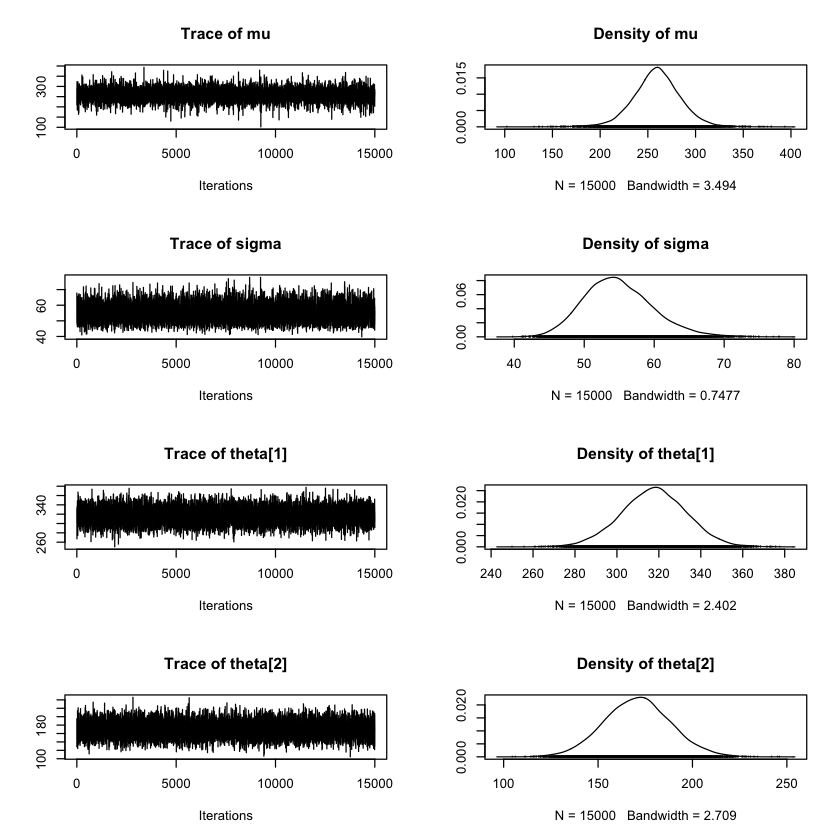

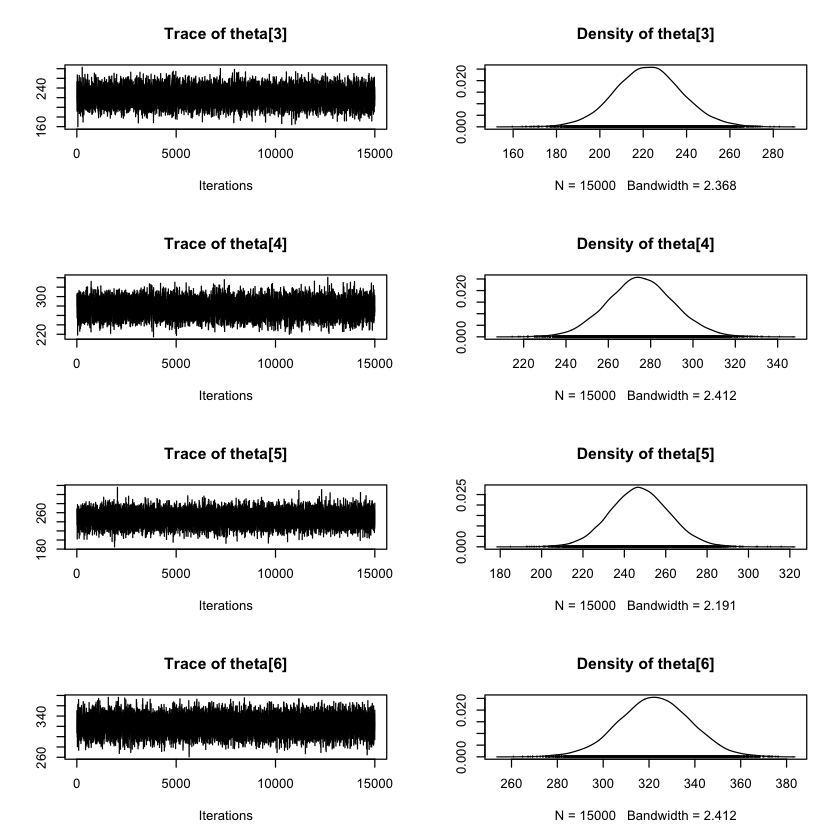

In [24]:
plot(mod.hier$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



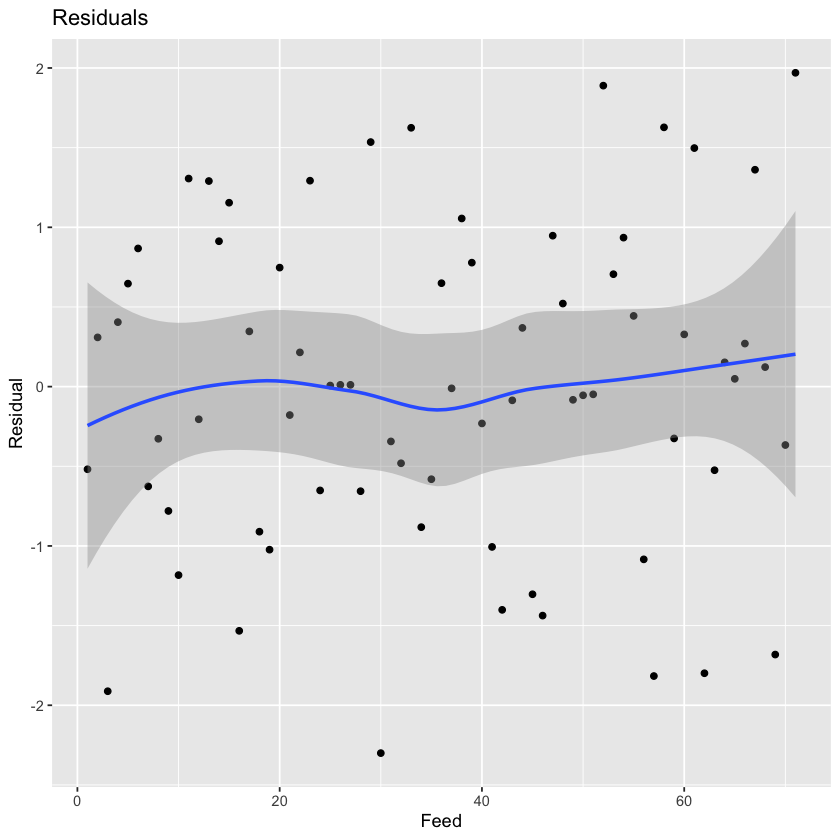

In [25]:
res = data$weight - mod.hier$coefs[3:8][data$feed]
gg_resid(res, normalize=TRUE)

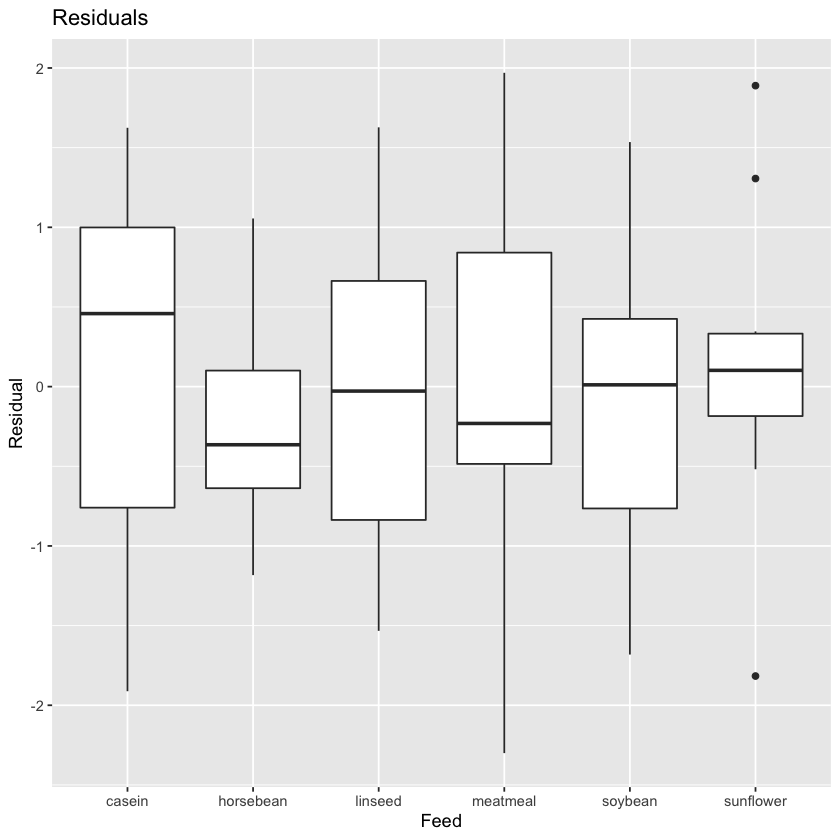

In [26]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

### Heterogenous Variance


The hierarchical model assumes that each group mean $\theta_j$ and variance $\sigma^2$ come from separate distributions. It also assumes that $\theta_j$ and $\sigma_j$ each share a prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma_j) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

$$ \frac{1}{\sigma^2_j} \sim Exp(1) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates an overall mean $\mu$ of approximately 258.0694. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[316.3469, 165.6013, 221.3979, 274.6762, 247.0059, 324.0416\]. Estimates for standard deviation $\sigma_{1 \dots j}$ are: \[63.0679, 38.1755, 51.1029, 63.0624, 52.893, 47.9474\].

Penalized deviance: 785.4 is slightly higher than the pooled model with homogenous variance.

Convergence looks fine, and the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [27]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma[feed[i]])
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
    prec.sigma[j] ~ dexp(1)
    sigma[j] = sqrt(1/prec.sigma[j])
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  tau = sqrt(1/prec.tau)
  
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier.var.het = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 14
   Total graph size: 174

Initializing model



#### Results

In [28]:
summary(mod.hier.var.het$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean    SD Naive SE Time-series SE
mu       258.27 26.34  0.21504        0.22705
sigma[1]  63.38 13.96  0.11396        0.12265
sigma[2]  38.13  9.44  0.07707        0.09143
sigma[3]  51.11 10.94  0.08931        0.09950
sigma[4]  62.96 13.98  0.11413        0.12359
sigma[5]  53.02 10.52  0.08592        0.09077
sigma[6]  47.85 10.35  0.08451        0.09533
theta[1] 316.42 18.30  0.14943        0.16859
theta[2] 165.66 12.91  0.10545        0.12048
theta[3] 221.67 14.93  0.12190        0.12727
theta[4] 274.49 18.30  0.14940        0.15569
theta[5] 247.27 13.93  0.11371        0.11263
theta[6] 323.82 14.16  0.11563        0.12777

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       204.48 242.41 258.33 274.44 310.39
sigma[1]  43.04  53.63  61.09  70.54 

In [29]:
round(mod.hier.var.het$coefs, 4)

mu sigma[1] sigma[2] sigma[3] sigma[4] sigma[5] sigma[6] theta[1] 
258.2723  63.3819  38.1260  51.1112  62.9644  53.0168  47.8542 316.4188 
theta[2] theta[3] theta[4] theta[5] theta[6] 
165.6568 221.6709 274.4868 247.2660 323.8231

In [30]:
(dic.hier.var.het = dic.samples(mod.hier.var.het$obj, n.iter=1e3))

Mean deviance:  772.2 
penalty 12.98 
Penalized deviance: 785.2 

#### Convergence

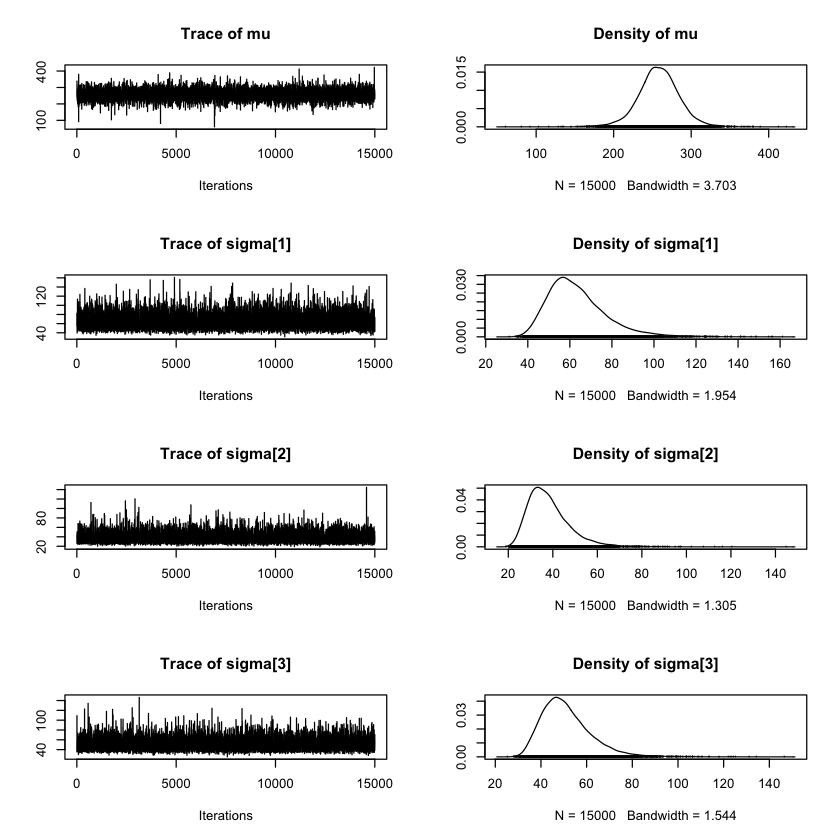

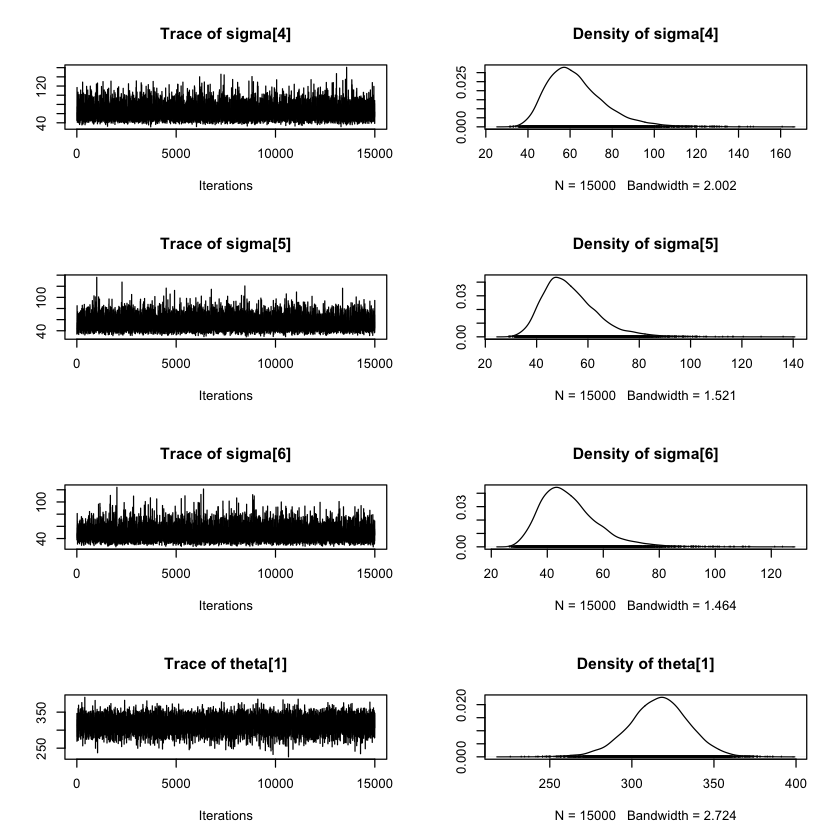

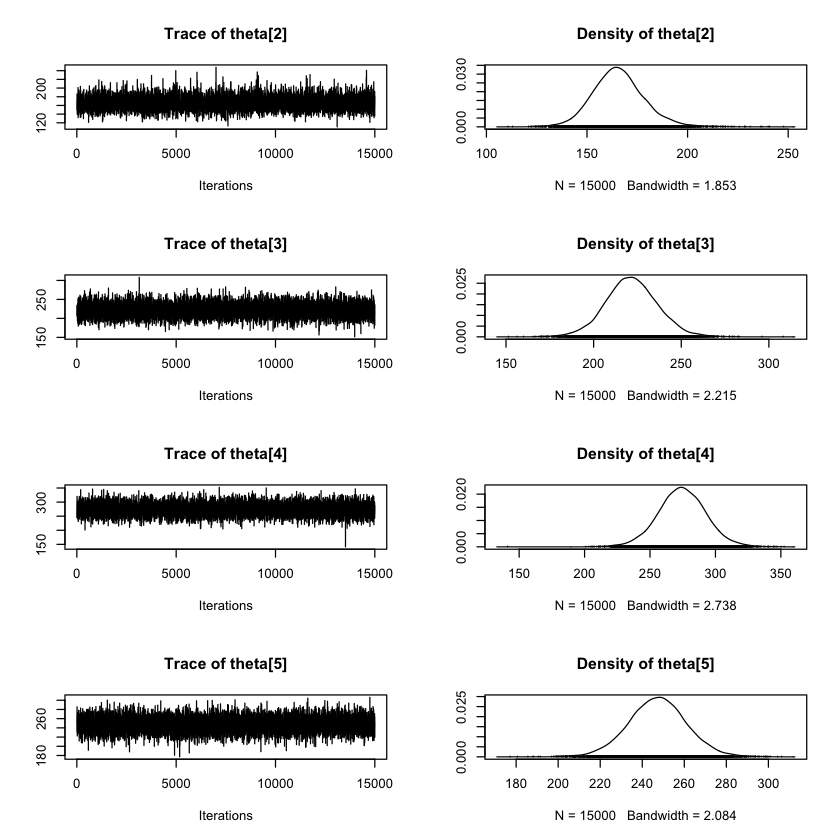

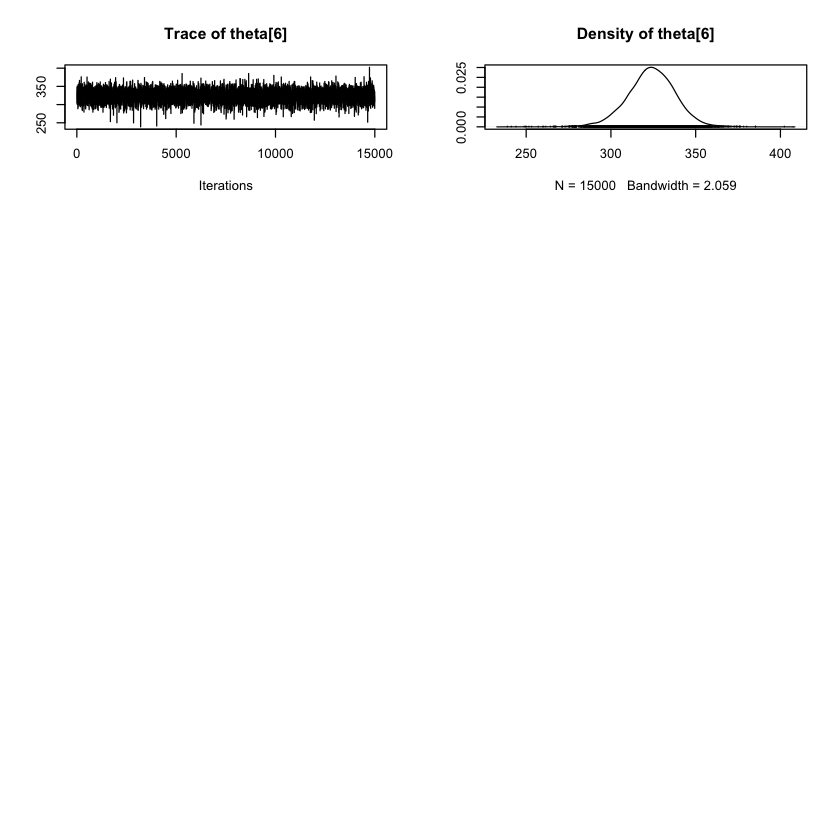

In [31]:
plot(mod.hier.var.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



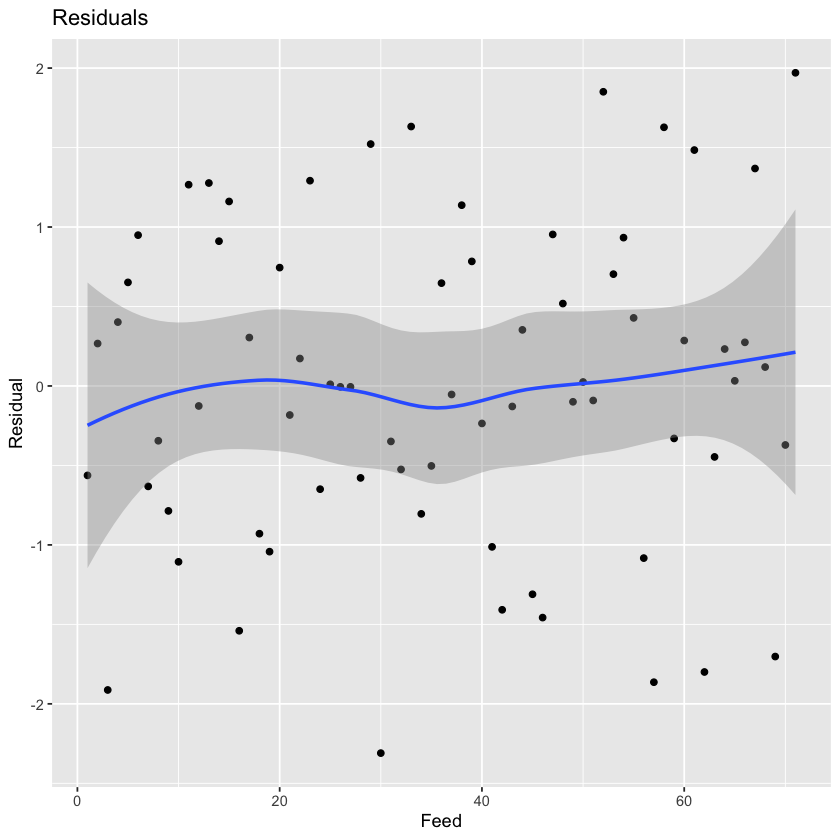

In [32]:
res = data$weight - mod.hier.var.het$coefs[8:13][data$feed]
gg_resid(res, normalize=TRUE)

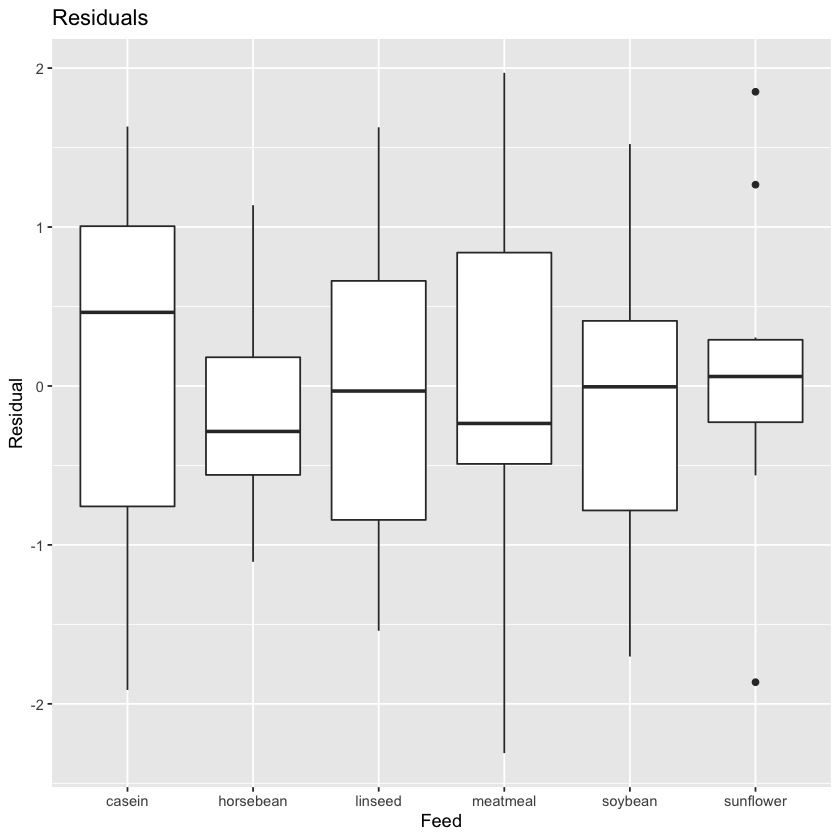

In [33]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Heterogenous Model

The heterogenous model assumes that each group mean $\theta_j$ comes from a separate distribution, but share a common variance $\sigma^2$. It also assumes that each $\theta_j$ comes from a separate prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu_j, \tau_j) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates very similar parameters for the standard deviation of priors $\tau_j$. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[323.4463, 159.3786, 218.6452, 276.5362, 246.7235, 328.2184\].

Penalized deviance: 780.7 is slightly higher than the pooled model with homogenous variance.

We increase sample size (per chain) to 50,000 to improve convergence; the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [34]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu[j], prec.tau[j])
    mu[j] ~ dnorm(0, 1.0/1.0e6)
    prec.tau[j] ~ dexp(1)
    tau[j] = sqrt(1/prec.tau[j])
  }
  
  prec.sigma ~ dexp(1)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "tau")

mod.het = run_sim(
    model.str = mod_string,
    data = data_jags,
    params = params,
    burn_in=5e3,
    n_iter=5e4
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 19
   Total graph size: 179

Initializing model



#### Results

In [35]:
summary(mod.het$sim)


Iterations = 5001:55000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
tau[1]     1.748  2.399 0.006193        0.01187
tau[2]     1.749  3.581 0.009247        0.01604
tau[3]     1.777  2.811 0.007257        0.01355
tau[4]     1.792  3.414 0.008815        0.01610
tau[5]     1.773  3.225 0.008326        0.01580
tau[6]     1.768  3.047 0.007867        0.01431
theta[1] 323.184 15.759 0.040690        0.43849
theta[2] 160.437 17.065 0.044061        0.49772
theta[3] 218.806 15.709 0.040560        0.42424
theta[4] 277.518 16.730 0.043197        0.47985
theta[5] 245.951 14.989 0.038700        0.39699
theta[6] 328.296 15.747 0.040659        0.43728

2. Quantiles for each variable:

             2.5%      25%     50%     75%   97.5%
tau[1]     0.5206   0.8477   1.199   1.874   6.180
tau[2]     0.5200   0.8479   1.193   1.85

In [36]:
round(mod.het$coefs, 4)

tau[1]   tau[2]   tau[3]   tau[4]   tau[5]   tau[6] theta[1] theta[2] 
  1.7479   1.7495   1.7769   1.7919   1.7733   1.7684 323.1842 160.4369 
theta[3] theta[4] theta[5] theta[6] 
218.8056 277.5181 245.9507 328.2959

In [37]:
(dic.het = dic.samples(mod.het$obj, n.iter=1e3))

Mean deviance:  771 
penalty 7.478 
Penalized deviance: 778.5 

#### Convergence

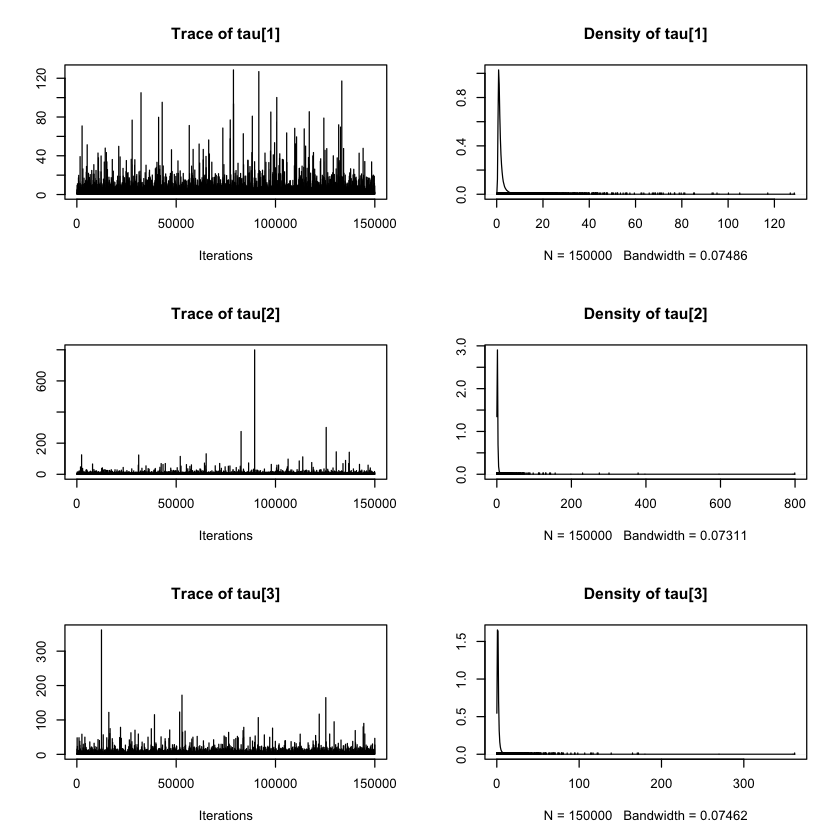

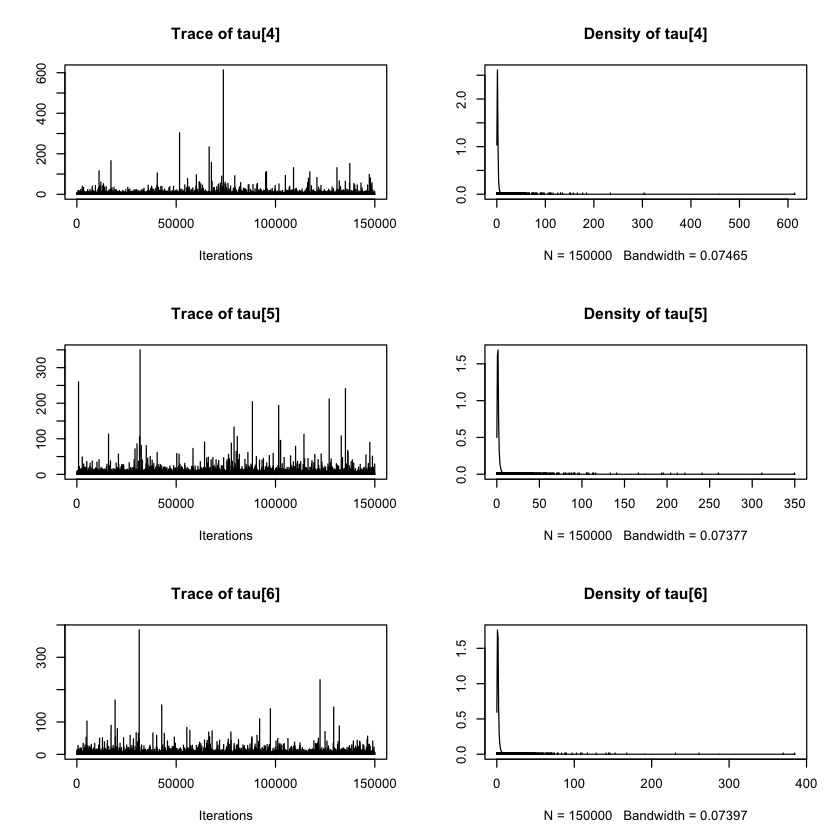

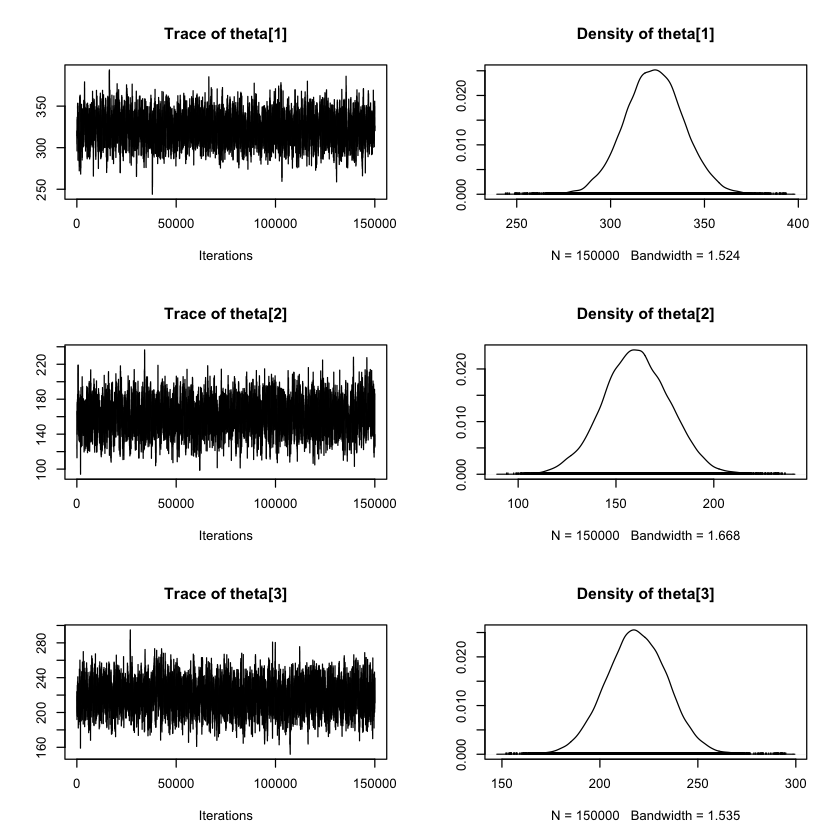

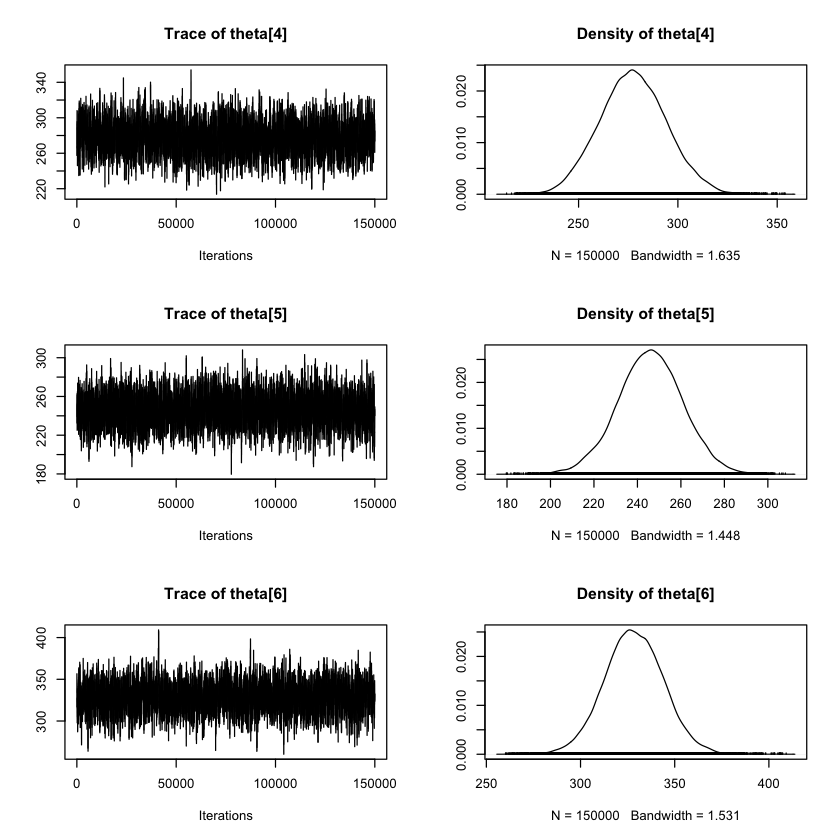

In [38]:
plot(mod.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



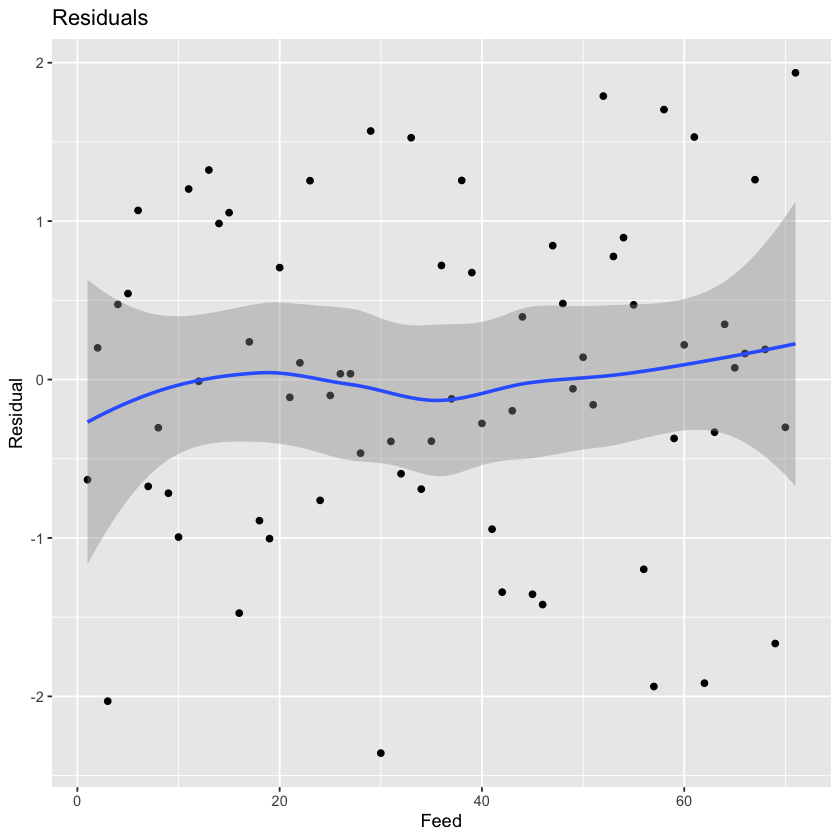

In [39]:
res = data$weight - mod.het$coefs[7:12][data$feed]
gg_resid(res, normalize=TRUE)

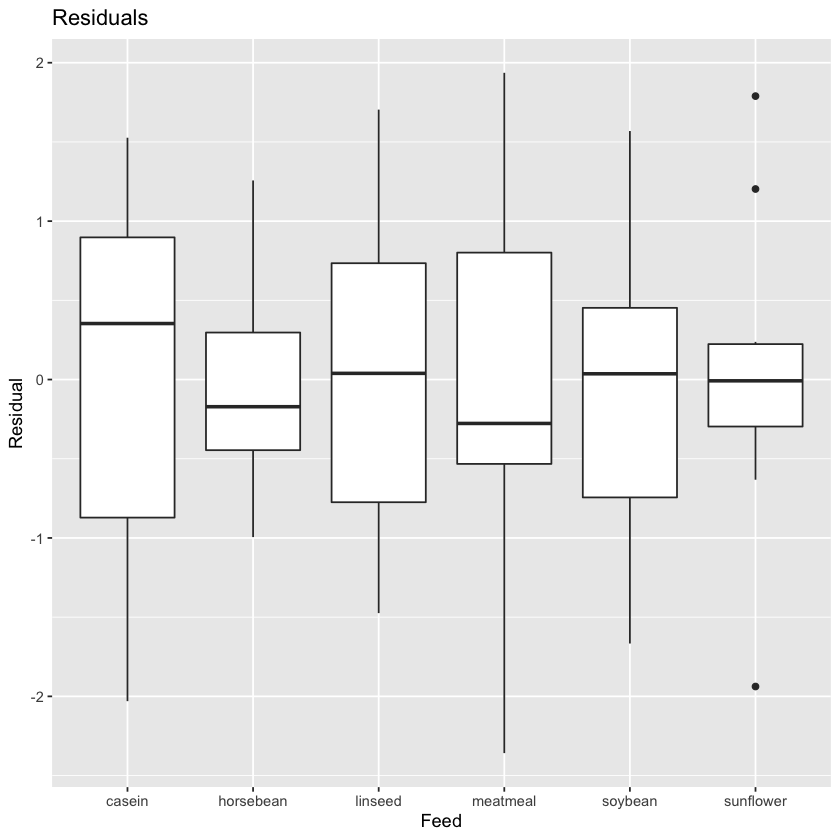

In [40]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

### Comparing Parameters

In [41]:
tibble(
    "Base"=round(coef(mod.base), 4),
    "Hierarchical"=round(mod.hier$coefs[3:8], 4),
    "Hierarchical, Het Var"=round(mod.hier.var.het$coefs[8:13], 4),
    "Heterogenous"=round(mod.het$coefs[7:12], 4)
    )


Base,Hierarchical,"Hierarchical, Het Var",Heterogenous
<dbl>,<dbl>,<dbl>,<dbl>
323.5833,317.6178,316.4188,323.1842
160.2000,170.8767,165.6568,160.4369
218.7500,222.4687,221.6709,218.8056
276.9091,275.2684,274.4868,277.5181
246.4286,247.3842,247.2660,245.9507
328.9167,322.5545,323.8231,328.2959


## Posterior Analysis

### Posterior Distributions of Theta

In [42]:
set.seed(43)
N = 1e4
post.dist = list()
for (i in 1:6) {
    col = glue("theta[{i}]")
    theta.post = sample(mod.hier$csim[, col], N, replace = TRUE)
    sigma.post = sample(mod.hier$csim[, "sigma"], N, replace = TRUE)
    z = rnorm(N, mean=theta.post, sd=sigma.post)
    post.dist[[col]] = z
}

post.dist = as_tibble(post.dist)

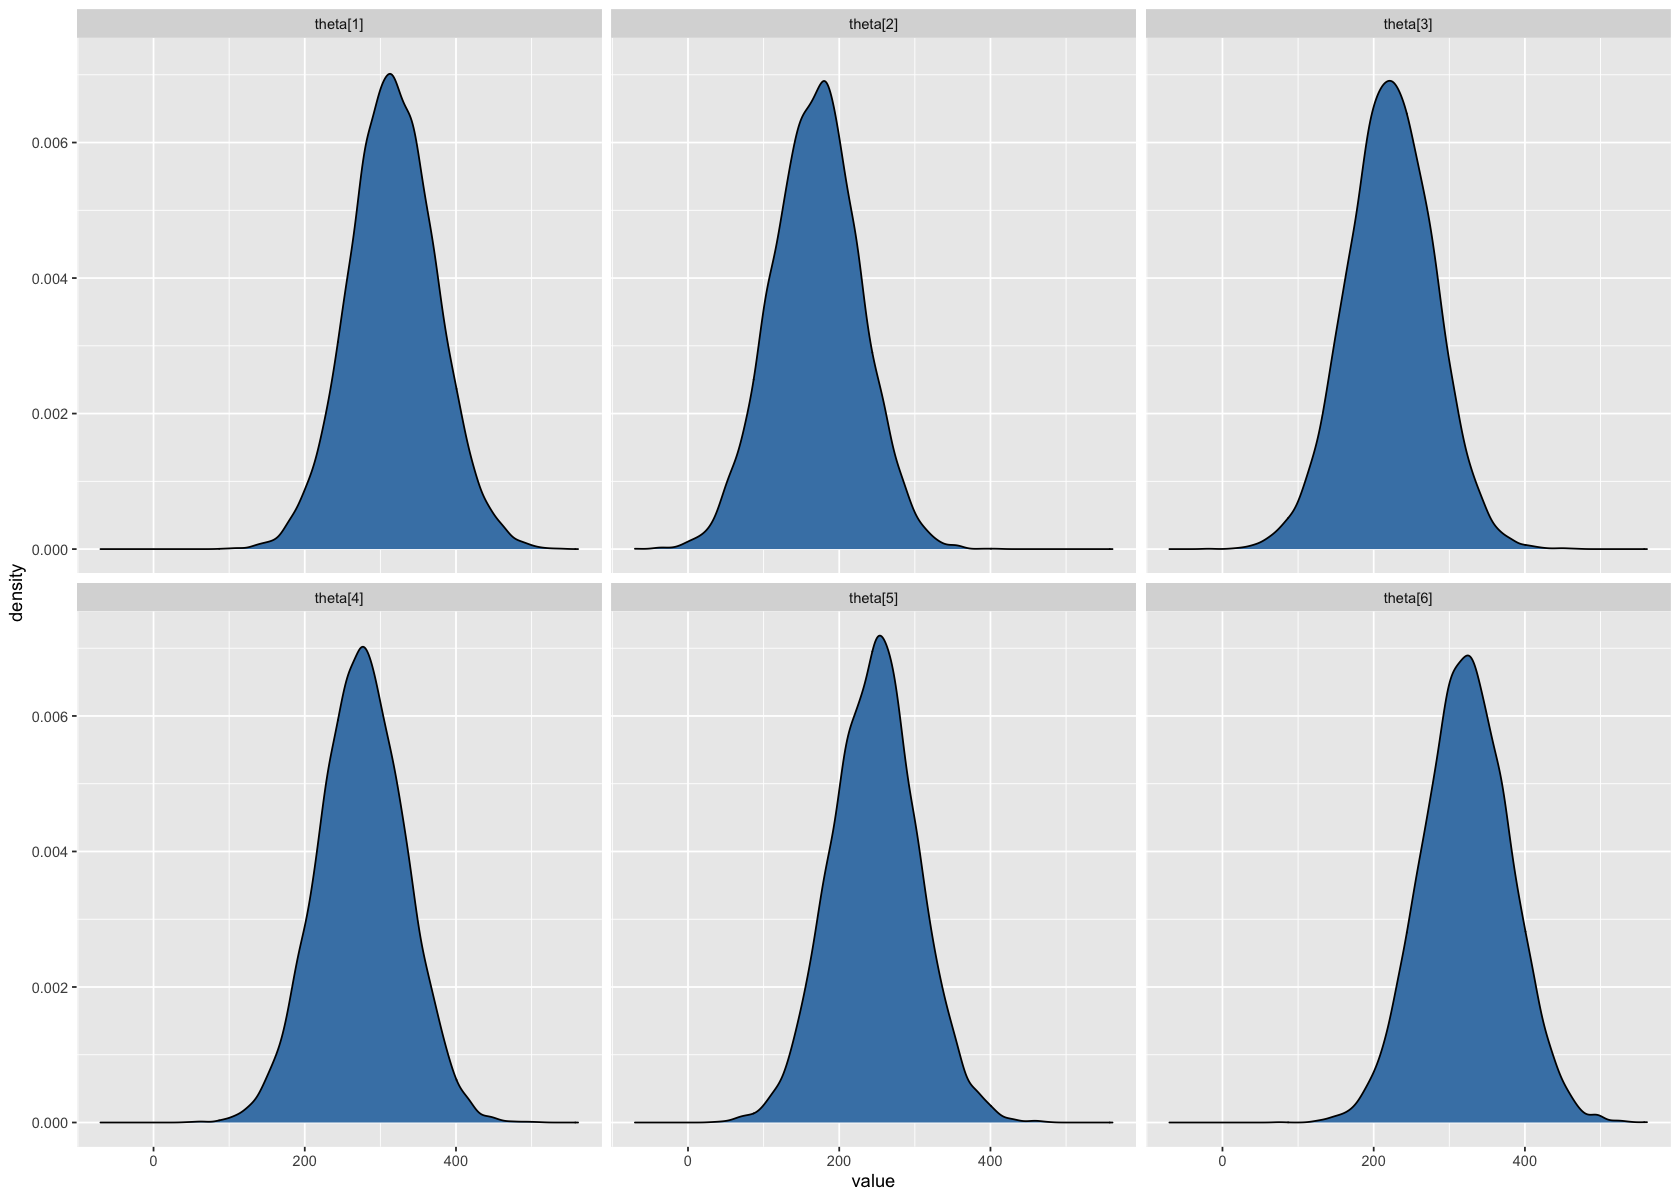

In [43]:
default_options = options()
options(repr.plot.width=14, repr.plot.height=10)

post.dist %>%
    pivot_longer(everything()) %>%
    ggplot(aes(x=value)) +
    geom_density(fill="steelblue") +
    facet_wrap(~name)
    

### Answers to Questions

1. Is there a significant difference in weights amongst the various feed types? 
2. If so, what is the probability that a specific feed type will outperform other feed types?

There is a statisticaly significant difference in weights amongst the various feed types, particularly when comparing casein or sunflower to the other four.

While sunflower feed outperforms the other four types with probability of 71% probability or more, it's unclear that it will outperform casein. Posterior predictive samples estimate that sunflower feed will only outperform casein 52% of the time.  Given the choice between sunflower or casein feeds, it's better to choose the least expensive.

In [44]:
post.dist %>% colMeans()

theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
316.8075 169.2394 222.2573 275.3473 246.9519 322.4704

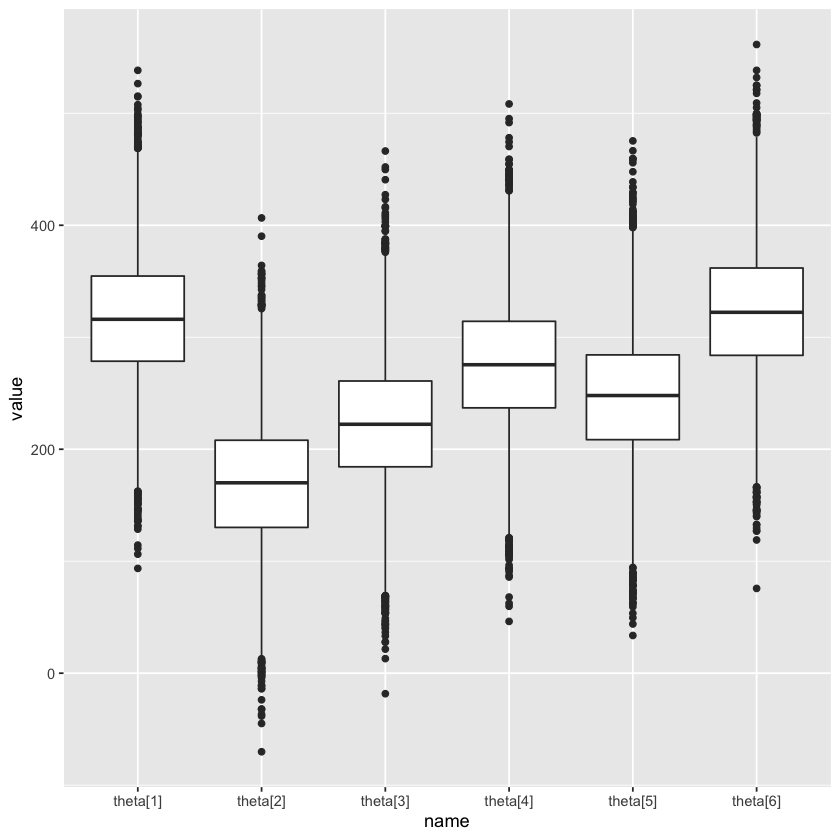

In [45]:
options(default_options)

post.dist %>%
    pivot_longer(everything()) %>%
    ggplot(aes(x=name, y=value, group=name)) +
    geom_boxplot()

In [46]:
feeds = levels(data$feed_name)
for (i in 1:5) {
    prob = mean(post.dist[, "theta[6]"] > post.dist[, glue("theta[{i}]")])
    print(glue("Probability that {feeds[6]} > {feeds[i]}: {prob}"))
    }

Probability that sunflower > casein: 0.5257
Probability that sunflower > horsebean: 0.9722
Probability that sunflower > linseed: 0.8944
Probability that sunflower > meatmeal: 0.7158
Probability that sunflower > soybean: 0.8265


In [47]:
feeds = levels(data$feed_name)
for (i in 2:6) {
    prob = mean(post.dist[, "theta[1]"] > post.dist[, glue("theta[{i}]")])
    print(glue("Probability that {feeds[1]} > {feeds[i]}: {prob}"))
    }

Probability that casein > horsebean: 0.9673
Probability that casein > linseed: 0.8806
Probability that casein > meatmeal: 0.6939
Probability that casein > soybean: 0.8069
Probability that casein > sunflower: 0.4743


## Conclusion

While sunflower feed outperforms the other four types with probability of 71% probability or more, it's unclear that it will outperform casein. Posterior predictive samples estimate that sunflower feed will only outperform casein 52% of the time.  Given the choice between sunflower or casein feeds, it's better to choose the least expensive.